# Contenido

1. **Carga de librerías y datos**  
   - 1.a. Librerías  
   - 1.b. Carga de datos

2. **Optimización**  
   - 2.a. Filtrado
   - 2.b. Nearest Neighbour con probabilidades
   - 2.c. Visualización


# 1. Carga de librerías y datos

## 1.a. Librerías

In [1]:
import pandas as pd
import random 
import time
import os
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import plotly.io as pio

from Funciones_nearest_probabilidad import funcion_objetivo, cantidad_estaciones, encontrar_estaciones_cercanas, procesar_estaciones, localizacion_segun_ruta, graficar_rutas_camiones

## 1.b. Carga de datos

In [2]:
# Predicciones
predicciones = pd.read_csv('Predicciones.csv', index_col = 0).round()

# Información previa para conocer las condiciones de salida
salida = pd.read_parquet('../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/BICICLETAS_HORARIO_2022_2023_FILTRADO.parquet').round()

# Capacidad de las estaciones 
capacidad = pd.read_parquet('../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/CAPACIDAD.parquet')

# Tiempos de viaje entre estaciones
tiempos_viaje = pd.read_csv('../1-DATOS/2-DATOS PROCESADOS/DISTANCIAS/Matriz de tiempos.csv', index_col = 0)

In [3]:
predicciones.head(5)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
2023-10-05 09:00:00,2.0,3.0,1.0,1.0,5.0,4.0,7.0,15.0,20.0,30.0,...,22.0,12.0,12.0,3.0,4.0,1.0,0.0,10.0,1.0,1.0
2023-10-05 10:00:00,3.0,4.0,2.0,3.0,4.0,6.0,8.0,15.0,20.0,28.0,...,22.0,12.0,11.0,2.0,4.0,1.0,0.0,11.0,1.0,1.0
2023-10-05 11:00:00,4.0,4.0,3.0,4.0,4.0,7.0,9.0,15.0,19.0,27.0,...,21.0,12.0,11.0,2.0,6.0,1.0,1.0,12.0,2.0,1.0
2023-10-05 12:00:00,6.0,5.0,4.0,5.0,3.0,7.0,11.0,15.0,17.0,25.0,...,20.0,13.0,10.0,1.0,4.0,2.0,1.0,11.0,3.0,1.0
2023-10-05 13:00:00,8.0,6.0,5.0,6.0,3.0,6.0,12.0,15.0,16.0,23.0,...,19.0,14.0,9.0,1.0,2.0,2.0,1.0,11.0,5.0,1.0


In [4]:
salida.index = pd.to_datetime(salida.index)
predicciones.index = pd.to_datetime(predicciones.index)
salida.columns = salida.columns.astype(str)
predicciones.columns = predicciones.columns.astype(str)

salida = salida[salida.index == (predicciones.index[0]- pd.Timedelta(hours=1))]
salida

station_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
FECHA,,,,,,,,,,,,,,,,,,,,,
2023-10-05 08:00:00,1.0,1.0,0.0,1.0,6.0,3.0,6.0,16.0,21.0,31.0,...,24.0,14.0,12.0,3.0,4.0,0.0,0.0,9.0,1.0,2.0


In [5]:
informacion = pd.concat([salida, predicciones])
informacion.head(5)

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,...,450.0,452.0,458.0,490.0,465.0,502.0,503.0,52.0,91.0,467.0
2023-10-05 08:00:00,1.0,1.0,0.0,1.0,6.0,3.0,6.0,16.0,21.0,31.0,...,24.0,14.0,12.0,3.0,4.0,0.0,0.0,9.0,1.0,2.0
2023-10-05 09:00:00,2.0,3.0,1.0,1.0,5.0,4.0,7.0,15.0,20.0,30.0,...,22.0,12.0,12.0,3.0,4.0,1.0,0.0,10.0,1.0,1.0
2023-10-05 10:00:00,3.0,4.0,2.0,3.0,4.0,6.0,8.0,15.0,20.0,28.0,...,22.0,12.0,11.0,2.0,4.0,1.0,0.0,11.0,1.0,1.0
2023-10-05 11:00:00,4.0,4.0,3.0,4.0,4.0,7.0,9.0,15.0,19.0,27.0,...,21.0,12.0,11.0,2.0,6.0,1.0,1.0,12.0,2.0,1.0
2023-10-05 12:00:00,6.0,5.0,4.0,5.0,3.0,7.0,11.0,15.0,17.0,25.0,...,20.0,13.0,10.0,1.0,4.0,2.0,1.0,11.0,3.0,1.0


In [6]:
# Selección de estaciones
estaciones = set(informacion.columns)

# Filtrado y transformación de la matriz de tiempos
tiempos_viaje = (
    tiempos_viaje.loc[tiempos_viaje.index.astype(str).isin(estaciones), list(estaciones)]
    .div(60)
    .round()
)

# Filtrado del conjunto que contiene las capacidades y conversión a diccionario
capacidad.columns = ["Station", "Capacidad"]
capacidad['Station'] = capacidad['Station'].astype(float).astype(str)
capacidad = capacidad.loc[capacidad['Station'].isin(estaciones)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()

# 2. Optimización

Se quiere minimizar la cantidad de horas que las estaciones del sistema se encuentran en riesgo de estar desabastecidas o saturadas.

In [7]:
valor = funcion_objetivo(informacion[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 795.


In [8]:
resumen = cantidad_estaciones(informacion[1:9], capacidad_dict, limite_inferior = 1, limite_superior = 3/4)

La cantidad de estaciones en riesgo de estar desabastecidas en algún momento del período son: 180
La cantidad de estaciones en riesgo de estar saturadas en algún momento del período son: 95


In [9]:
resumen = cantidad_estaciones(informacion[1:9], capacidad_dict, limite_inferior = 2, limite_superior = 2/3)

La cantidad de estaciones en riesgo de estar desabastecidas en algún momento del período son: 275
La cantidad de estaciones en riesgo de estar saturadas en algún momento del período son: 128


## 2.a. Filtrado


Se considera el segundo conjunto de datos (con más cantidad de estaciones), pero en el algoritmo tienen prioridad de visita las estaciones en riesgo con límite_inferior = 1 y límite_superior = 3/4 de la capacidad.

In [10]:
estacion_salida = pd.Series(['1.0'])
estaciones_intervenidas = resumen['Station']

if estacion_salida.iloc[0] in estaciones_intervenidas.values:
    estaciones_algoritmo = estaciones_intervenidas
else: 
    # Unión estación de salida con las que necesitan intervención
    estaciones_algoritmo = pd.concat([estacion_salida, estaciones_intervenidas], ignore_index=True)
    
# Filtrado en el conjunto de datos de las estaciones 
informacion = informacion[estaciones_algoritmo]
capacidad = capacidad[capacidad['Station'].isin(estaciones_algoritmo)]
capacidad_dict = capacidad.set_index('Station')['Capacidad'].to_dict()
tiempos_viaje.index = tiempos_viaje.index.astype(str)
tiempos_viaje = tiempos_viaje[estaciones_algoritmo]
tiempos_viaje = tiempos_viaje[tiempos_viaje.index.isin(estaciones_algoritmo)]

## 2.b. Nearest Neighbour con probabilidades

Función para ejecutar el algoritmo:

In [11]:
random.seed(42)

num_minutes = informacion.shape[0]*60

visitas_estaciones = []
tiempo_estaciones = []

def optimizacion_probabilidad(informacion = informacion, num_camiones = 2, capacidad_camion = 50, bicicletas_camion = 25, posicion_inicial = '1.0'):
    """
    Función para optimizar las rutas de los camiones, en función de la disponibilidad de bicicletas en las 
     estaciones de un sistema de bicicletas compartidas.

    Entradas:
    - informacion: DataFrame que contiene datos predictivos sobre la cantidad de bicicletas en las estaciones.
    - num_camiones: Número de camiones disponibles para la operación (por defecto 2).
    - capacidad_camion: Capacidad máxima de bicicletas que puede llevar cada camión (por defecto 50).
    - bicicletas_camion: Número inicial de bicicletas disponibles en cada camión (por defecto 25).
    - posicion_inicial: Estación inicial donde comienzan los camiones (por defecto '1.0').

    Salidas:
    - resultados: DataFrame que muestra la ruta, momento de visita y bicicletas transportadas por cada camión 
      en cada iteración, correspondiente a la mejor solución encontrada según el criterio de la función objetivo.

    """
    valor_minimo = float('inf')
    iteraciones_bucle = 0
    tiempo_maximo = 600 # Este valor se puede modificar según las necesidades
    tiempo_inicio = time.time()

    # Ciclo principal controlado por el tiempo
    while time.time() - tiempo_inicio < tiempo_maximo:
        # Registro de visitas a estaciones
        visitas_estaciones = []
        tiempo_estaciones = []
        camiones = [
        {"id": i, "bicicletas_camion": bicicletas_camion, "posicion": posicion_inicial, "ruta": [posicion_inicial], "bicicletas_iteracion": [bicicletas_camion], "t": 0, "tiempo_vuelta": 0, "param" : False, "tiempo visita estaciones" : [0]}
        for i in range(num_camiones)
        ]

        iteraciones_bucle +=1
        print(time.time() - tiempo_inicio, iteraciones_bucle)

        data_inicial = informacion.copy()

        while any(camion["t"] + camion["tiempo_vuelta"] < num_minutes - 60 for camion in camiones):
            for camion in camiones:
                restriccion = pd.DataFrame({'visita': visitas_estaciones, 'tiempo visita': tiempo_estaciones}) 
                if camion["t"] + camion["tiempo_vuelta"] >= num_minutes - 60:
                    continue
            
                lista_tiempos_vacía, lista_estaciones_vacía, lista_tiempos_llena, lista_estaciones_llena = encontrar_estaciones_cercanas(
                    camion["posicion"], camion["t"], estaciones_algoritmo, capacidad, tiempos_viaje, data_inicial, num_minutes, restriccion, posicion_inicial, limite_inferior=1, limite_superior=3/4
                )
                procesar_estaciones(camion, lista_tiempos_vacía, lista_estaciones_vacía, lista_tiempos_llena, lista_estaciones_llena, capacidad, data_inicial, tiempos_viaje, capacidad_camion, visitas_estaciones, tiempo_estaciones)

        # Retorno a la estación central
        for i, camion in enumerate(camiones):
            tiempo_vuelta = int(tiempos_viaje.loc[camion["posicion"], "1.0"])
            camion["t"] += tiempo_vuelta - 5 if camion["param"] else + tiempo_vuelta
            camion["posicion"] = "1.0"
            camion["ruta"].append("1.0")
            camion["tiempo visita estaciones"].append(camion["t"])
            camion["bicicletas_iteracion"].append(camion["bicicletas_camion"])


        # Calcular el valor de la función objetivo
        valor = funcion_objetivo(data_inicial[1:9], capacidad_dict, limite_inferior=1, limite_superior=3/4)
        if valor < valor_minimo:
            mejor_iteraciones = iteraciones_bucle
            mejores_camiones = camiones
            valor_minimo = valor

    dataframes = []
    for i, camion in enumerate(mejores_camiones):
        df = pd.DataFrame({
            "CAMIÓN": i + 1,
            "RUTA": camion["ruta"],
            "MOMENTO DE VISITA": camion["tiempo visita estaciones"],
            "BICICLETAS EN CAMIÓN": camion["bicicletas_iteracion"]
        })
        dataframes.append(df)
    resultados = pd.concat(dataframes, ignore_index=True)
    print(f'\nLa cantidad de minutos con estaciones en riesgo de estar desabastecidas o saturadas tras el reposicionamiento es: {valor_minimo}. Se ha obtenido este resultado en la iteracion {mejor_iteraciones}.')
    return resultados


In [12]:
resultados = optimizacion_probabilidad(informacion = informacion, num_camiones = 3, capacidad_camion = 50, bicicletas_camion = 25, posicion_inicial = '1.0')

0.0 1
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 598.
67.90898752212524 2
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 606.
137.0567557811737 3
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 591.
205.59673380851746 4
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 612.
275.2230501174927 5
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 576.
348.0883672237396 6
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 592.
419.88063287734985 7
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 598.
493.61278462409973 8
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 596.
565.1006376743317 9
La cantidad de horas con estaciones en riesgo de estar desabastecidas o saturadas es: 601.

La cantidad

In [13]:
resultados[resultados.CAMIÓN == 1] # Ejemplo

,CAMIÓN,RUTA,MOMENTO DE VISITA,BICICLETAS EN CAMIÓN
0,1,1.0,0,25
1,1,3.0,3,10
2,1,412.0,10,19
3,1,91.0,18,10
4,1,66.0,24,21
5,1,110.0,31,16
6,1,140.0,37,9
7,1,111.0,42,0
8,1,180.0,52,6
9,1,404.0,57,23


In [14]:
camiones = resultados['CAMIÓN'].unique()

for camion in camiones:
    resultados[resultados['CAMIÓN'] == camion].to_csv(f'camion_{camion}.csv', index=False)

## 2.c. Visualización


In [15]:
todas_localizaciones = pd.DataFrame()
for camion_id, grupo_camion in resultados.groupby("CAMIÓN"):
    ruta = grupo_camion["RUTA"].dropna().astype(str).tolist()

    localizacion = pd.read_parquet('../1-DATOS/2-DATOS PROCESADOS/BICING/INFORMACION COMPLETA/GEOLOCALIZACION.parquet')
    localizacion = localizacion_segun_ruta(ruta, localizacion)
    localizacion["camion_id"] = f"Camión {camion_id}"

    todas_localizaciones = pd.concat([todas_localizaciones, localizacion], ignore_index=True)

print("Localizaciones de todas las rutas:\n")
todas_localizaciones.head(5)

Localizaciones de todas las rutas:



,station_id,lat,lon,camion_id
0,1.0,41.397978,2.180107,Camión 1
1,3.0,41.394156,2.181331,Camión 1
2,412.0,41.389309,2.172746,Camión 1
3,91.0,41.381250,2.159474,Camión 1
4,66.0,41.389322,2.167839,Camión 1


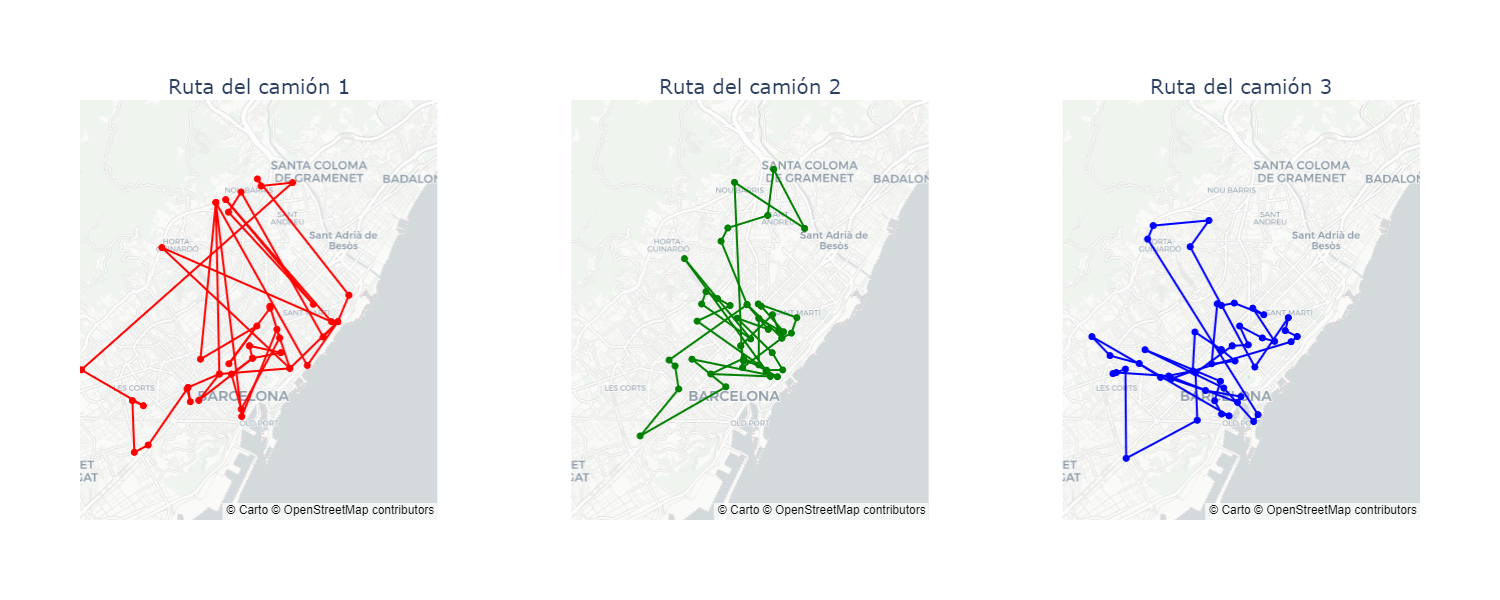

In [16]:
fig = graficar_rutas_camiones(todas_localizaciones)
# fig.write_image("rutas_camiones.png")
# fig.show()

static_image = pio.to_image(fig, format="png", engine="kaleido")
Image(static_image) # Muestra la imagen estática